This notebook will show how you can take the attention scores (query dot key) and get a graph from them with edge weights equal to those scores.

We can do various different kinds of analysis on those graphs, for example, here we will show what happens when you take the min spanning tree of that graph.

First, install dependencies:

`pip install graphviz networkx`

In [124]:
# Load the model
from transformers import AutoTokenizer, AutoModel, AutoModelWithLMHead
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelWithLMHead.from_pretrained("gpt2")

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


We need to "monkey patch" our attention function to add something that'll let us see the outputs of the dot product of the keys and biases

In [125]:
import torch
from torch import nn

# simple module that we can use pytorch hooks to let us see intermediate anything
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

# Mostly just copy pasted from https://huggingface.co/transformers/_modules/transformers/modeling_gpt2.html#GPT2Model
# only tweak is adding the visualize so I can add a hook to see intermediate weights
def _attn(self, q, k, v, attention_mask=None, head_mask=None, output_attentions=False):
    w = torch.matmul(q, k)
    if self.scale:
        w = w / (float(v.size(-1)) ** 0.5)
    nd, ns = w.size(-2), w.size(-1)

    if not self.is_cross_attention:
        # if only "normal" attention layer implements causal mask
        mask = self.bias[:, :, ns - nd : ns, :ns]
        w = torch.where(mask.bool(), w, self.masked_bias.to(w.dtype))

    if attention_mask is not None:
        # Apply the attention mask
        w = w + attention_mask

    w = nn.Softmax(dim=-1)(w)
    w = self.visualize(w) ###### ADDED THIS LINE SO WE COULD SEE WEIGHTS
    w = self.attn_dropout(w)

    # Mask heads if we want to
    if head_mask is not None:
        w = w * head_mask

    outputs = [torch.matmul(w, v)]
    if output_attentions:
        outputs.append(w)
    return outputs


In [126]:
from functools import partial
# This replaces the attentions with our custom thing above so we can inspect their values
def replaceAttentions(model):
    blocks = model.transformer.h
    for block in blocks:
        attn = block.attn
        nx = attn.c_proj.nf
        n_ctx = attn.bias.shape[2] # bias is (1,1,n_ctx, n_ctx)
        # give it a visualize module
        block.attn.visualize = Identity()
        # replace attention function with new one. We need to manually pass in self (a partial will pass curBlock as the first parameter) because monkey patching doesn't do that by default
        curBlock = block.attn
        block.attn._attn = partial(_attn, curBlock)


In [127]:
replaceAttentions(model)

Now we need to add a hook for each layer that takes the weights and converts them into a graph.

Note that this requires the global `words` to be set with the words of the sentence we passed into our model.

It also requires the global `graphs` to be set to an empty array, and it'll fill it with arrays containing graphs for each layer.

In [181]:
if "hooks" in dir() and hooks is not None: # check to see if the variable hooks exists. If so, we need to remove those hooks. This is important so if we rerun this cell it removes the old ones
    [hook.remove() for hook in hooks]
    hooks = None

import networkx as nx
# This callback will construct a networkx graph for each head from the given weights
def callback(module, inp, outp):
    global graphs
    global words
    weights = inp[0] # [batchSize, nHeads, sentenceLength, sentenceLength]
    batchSize, nHeads, sentenceLength, sentenceLength = weights.shape
    labels = [words[i] + "_" + str(i) for i in range(sentenceLength)] 
    graphsForThisLayer = []
    for h in range(nHeads):
        G = nx.DiGraph()
        for i in range(sentenceLength):
            G.add_node(labels[i])
        for i in range(sentenceLength):
            for j in range(sentenceLength):
                weight = weights[0,h,i,j].item()
                G.add_edge(labels[i], labels[j], weight=weight, label=f'{weight:.3f}')
        graphsForThisLayer.append(G)
    graphs.append(graphsForThisLayer)

# Add a hook for each block
hooks = [block.attn.visualize.register_forward_hook(callback) for block in model.transformer.h]

In [182]:
# Simple utility function, graphviz has better plotting (imo) than networkx so this converts from networkx to a graphviz dot
from networkx.drawing.nx_pydot import to_pydot
import graphviz
def nxToDot(graph):
    dot = graphviz.Digraph()
    for node in graph:
        dot.node(node)
    for node in graph:
        for edge, data in graph[node].items():
            dot.edge(node, edge, label=f'{data["weight"]:.3f}')
    return dot

['the', ' quick', ' brown', ' fox', ' jumped']


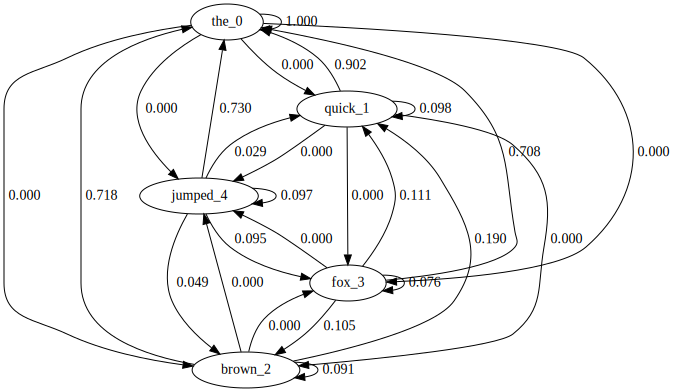

In [250]:
text = "the quick brown fox jumped"
# Encode the text into a list of integers
encoded_input = tokenizer(text, return_tensors='pt')
# Convert the integers back into character segments, to be used above when making the graphs
global words
words = [tokenizer.decode([x]) for x in encoded_input['input_ids'].flatten()]
print(words)
# reset the graphs array our callback above will populate
global graphs
graphs = []
# Actually pass the tokens through the model. This will call our callback
output = model(**encoded_input)
# Find the min spanning tree of the graph and plot it
from networkx.algorithms.tree.branchings import Edmonds
graph = graphs[-1][-1]
nxToDot(graph)

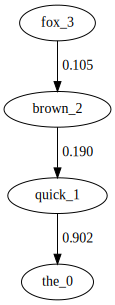

In [245]:
nxToDot(Edmonds(graph).find_optimum())

In [246]:
import networkx as nx
# keeps only the [kth:lth] highest connections
def topWeight(graph, k,l):
    newGraph = nx.DiGraph()
    for node in graph.nodes():
        newGraph.add_node(node)
    for node in graph.nodes():
        nodeData = graph[node] # nodeData.items() looks like [(word, {"weight": 0.8681942820549011, "label": '0.868'}), ...]
        weights = [(word, values['weight']) for (word, values) in nodeData.items()]
        # sort by weights, largest to smallest
        weights.sort(key=lambda x: -x[1])
        for word, weight in weights[0:1]:
            newGraph.add_edge(node, word, weight=weight)
    return newGraph

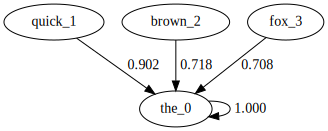

In [241]:
nxToDot(topWeight(graph,0,1))